# Solución 3: Árboles de Decisión

Esta es la tercera solución propuesta para la predicción de cáncer de pulmón utilizando computación evolutiva. Utilizaremos una población formada por árboles de decisión.

Los nodos hoja devuelven el resultado de la clasificación (1 en caso de predecir que el paciente presenta cáncer de pulmón, o 0 en caso de predecir que el paciente está sano). Cada nodo funcional esta asociado a un argumento, y tendrá dos nodos hijos, uno para cuando el argumento evalúe 1, y otro para cuando el argumento evalúe 0.

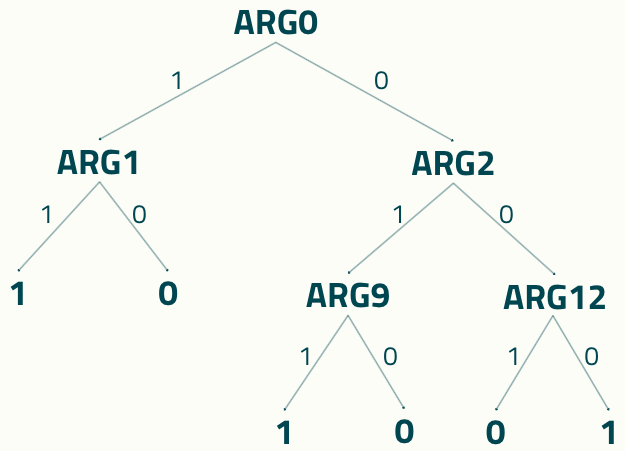

In [ ]:
from IPython.display import Image
Image('ArbolDecision.png')

# Lectura y preprocesado de datos

Antes de nada, es necesario leer los datos de *LungCancer.csv* y procesarlos de la manera adecuada.

In [ ]:
import pandas as pd
import random
import numpy as np
from google.colab import drive
from random import randint
import operator
from functools import partial

Montamos el Drive y añadimos la ruta donde está guardado el csv:

In [ ]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Computación Evolutiva/LungCancer.csv"

Mounted at /content/drive


Leemos y mostramos los datos:

In [ ]:
data=pd.read_csv(path)
data

,Sexo,Edad,Fumador,DedosAmarillos,Ansiedad,Hipertension,EnfermedadCronica,Fatiga,Alergia,Silbidos,ConsumidorAlcohol,Tos,DificultadRespirar,DificultadTragar,DolorPecho,CancerPulmon
0,M,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,M,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,F,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,M,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,F,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,F,59,0,1,1,1,0,0,1,1,0,1,0,1,0,1
280,F,59,1,0,0,0,1,1,1,0,0,0,1,0,0,0
281,M,55,1,0,0,0,0,1,1,0,0,0,1,0,1,0
282,M,46,0,1,1,0,0,0,0,0,0,0,0,1,1,0


Ahora preprocesamos los datos para transformar todos los predictores a variables binarias.
*   Utilizamos one hot encoding para transformar la variable categórica *Sexo*, que toma valores *M* y *F* en una variable numérica binaria que toma los valores 1 y 0.
*   Separamos los valores de la variable *Edad* en dos grupos 0 y 1, separados por la mediana.



In [ ]:
data['Sexo'] = data['Sexo'].replace({'M': 0, 'F': 1})
mediana = data['Edad'].median()
data['Edad'] = (data['Edad'] >= mediana).astype(int)
data

<ipython-input-5-a998fc17921f>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Sexo'] = data['Sexo'].replace({'M': 0, 'F': 1})


,Sexo,Edad,Fumador,DedosAmarillos,Ansiedad,Hipertension,EnfermedadCronica,Fatiga,Alergia,Silbidos,ConsumidorAlcohol,Tos,DificultadRespirar,DificultadTragar,DolorPecho,CancerPulmon
0,0,1,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,0,1,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,1,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,0,1,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,1,1,0,1,0,0,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,1,0,0,1,1,1,0,0,1,1,0,1,0,1,0,1
280,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0
281,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0
282,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0


Separamos los atributos de las etiquetas:

In [ ]:
X = data.drop(data.columns[-1], axis=1)
y = data[data.columns[-1]]

Al contrario que en las dos primeras soluciones, separaremos el conjunto de datos en los conjuntos de train, validación y test en vez de solo separarlo en train y test. En primer lugar separamos los datos en 80% train y 20% test. A continuación, apartaremos el 20% de los datos de train para dar lugar al conjunto de validación

Esta diferencia con las dos primeras soluciones se debe a que en este caso, utilizaremos el conjunto de validación para evitar que nuestra solución haga demasiado overfitting a los datos de train, como veremos más adelante.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Hemos notado que el conjunto de train está desbalanceado, así que lo balanceamos creando instancias sintéticas.

In [ ]:
from imblearn.over_sampling import SMOTE

s = SMOTE()
X_train, y_train = s.fit_resample(X_train, y_train)

y_train.value_counts()

,count
CancerPulmon,
1,159
0,159


# Implementación

## Definición de la clase árbol y sus métodos

En un primer lugar intentamos programar los árboles mediante la librería de programación genética *DEAP*, pero se nos hizo complicado implementar los árboles de decisión con esa librería. Finalmente optamos por implementar la clase árbol a mano. Dentro de la clase, existen los siguientes métodos principales.

*   **Método init:**
Inicializa una instancia de la clase árbol. El árbol tendrá único nodo que puede ser funcional (uno de los 15 argumentos de *LungCancer*) o terminal (1 o 0).

*   **Método populate:**
A partir de un árbol inicializado, se puebla el árbol de manera aleatoria. Nos aseguramos de que los argumentos no se repiten en un mismo camino para que el árbol tenga más sentido. El árbol tiene una profundidad máxima que es igual al número de argumentos, en este caso 15. Hemos decidido que la profundidad sea variable y no fija ya que cuanta mayor profundidad hay más overfitting, que es algo que queremos evitar.

*   **Método evaluate:**
Evaluar una cadena con un árbol, devuelve la etiqueta perdicha para esa cadena.

*   **Método fitness_function:**
Es la función de fitness de nuestro algoritmo. Se trata del accuracy del árbol en los datos de train.

*   **Método replace:**
Reemplaza un subárbol por otro. Se utilizará más adelante para el cruce.

*   **Método random_subtree:**
Elige un nodo aleatorio del árbol y devuelve un número asociado a dicho nodo y el subárbol que parte de él. Se utilizará más adelante para el cruce.

*   **Método copy:**
Copia un árbol.

*   **Método mutate:**
Muta un nodo aleatorio del árbol. El nodo mutado puede ser tanto terminal como funcional.

*   **Método plot:**
Imprime el árbol. Lo hemos utilizado para comprobar que populate, mutate y el cruce funcionaban correctamente.

A continuación se presenta la implementación de la clase.




In [ ]:
class Tree:



  ""
  "inicialization of the tree"
  ""
  def __init__(self, num_attributes, leaf="", taken_attributes=[]):

    # initialy the tree is just one node, so it does not have children
    self.child_yes = None
    self.child_no = None
    self.num_attributes = num_attributes

    # if the node is a leaf, asign terminal value
    if leaf == "T":
      self.info = "1"
    elif leaf == "F":
      self.info = "0"

    # if the node is not a leaf, asign an attribute that has not been used in the node's parent, grandparent, and so on
    else:

      # avoid arguments previously used by parent nodes
      choices = []
      for index in range(num_attributes):
        atrib = "ARG" + str(index)
        if atrib not in taken_attributes:
          choices.append(atrib)

      self.info = random.choice(choices)



  ""
  "populate the tree with non repeated random attributes and terminals, with a maximum depth"
  ""
  def populate(self, max_depth, taken_attributes):

    taken_attributes.append(self.info)

    # the tree children are terminals with probability = 0.3 or when the maximum depth is reached
    if random.random() < 0.3 or max_depth == 1:

      # asign 1 and 0 to the children
      if random.random() > 0.5:
        self.child_yes = Tree(self.num_attributes, leaf="T")
        self.child_no = Tree(self.num_attributes, leaf="F")
      else:
        self.child_yes = Tree(self.num_attributes, leaf="F")
        self.child_no = Tree(self.num_attributes, leaf="T")

      return

    # initialize children
    self.child_yes = Tree(self.num_attributes, taken_attributes=taken_attributes)
    self.child_no = Tree(self.num_attributes, taken_attributes=taken_attributes)

    a = taken_attributes.copy()
    b = taken_attributes.copy()

    # populate children
    self.child_yes.populate(max_depth - 1, taken_attributes=a)
    self.child_no.populate(max_depth - 1, taken_attributes=b)

    return



  ""
  "evaluate a chain using the tree"
  ""
  def evaluate(self, chain):

    # if the node is a leaf, return leaf value
    if self.info == "1" or self.info == "0":
      return self.info

    # evaluate attibute
    index = int(self.info[3:])

    # choose to follow "yes path" o "no path" depending on the attribute chain value
    if chain[index] == 1:
      return self.child_yes.evaluate(chain)

    return self.child_no.evaluate(chain)



  ""
  "given a set of chains and their respective classes, calculate the accuracy of the tree"
  ""
  def fitness_function(self, chains, labels):
    ok = 0

    # evaluate all the chains and compare results with their true labels
    for i in range(len(chains)):
      eval = int(self.evaluate(chains[i]))
      if eval == labels [i]:
        ok += 1

    # return percentage of accuracy
    return ok/len(chains)



  ""
  "auxiliary funcion of the random_subtree and mutate functions"
  "calculates the tree number of nodes"
  ""
  def num_nodes(self):

    # return 1 if the node is a terminal node
    if self.info == "1" or self.info == "0":
      return 1

    # if the node is functional, return 1 plus the number of nodes in the children
    return 1 + self.child_yes.num_nodes() + self.child_no.num_nodes()



  ""
  "auxiliary funcion of the random_subtree function"
  "adds one to the number of nodes visited, and returns itself if the tree corresponds to the chosen node"
  ""
  def visit(self, visited_nodes, chosen_node):
    subtree = None
    visited_nodes += 1

    # if the chosen node is the parent of the current tree
    if visited_nodes == chosen_node:
      subtree = self

    # return if the node is a terminal node
    if self.child_yes == None and self.child_no == None:
      return visited_nodes, subtree

    # visit children
    visited_nodes1, subtree1 = self.child_yes.visit(visited_nodes, chosen_node)
    visited_nodes2, subtree2 = self.child_no.visit(visited_nodes1, chosen_node)

    # if the subtree to be returned is the current tree, return itself
    if visited_nodes == chosen_node:
      return visited_nodes, subtree
    # if the subtree to be returned is in child_yes, return child_yes output
    elif subtree1:
      return visited_nodes1, subtree1
    # if the subtree to be returned is in child_no, return child_no output
    elif subtree2:
      return visited_nodes2, subtree2

    # if the node was not found in the current tree, return none
    return visited_nodes2, None



  ""
  "function to replace a node (chosen node) an its subtree for another one (subtree)"
  ""
  def replace(self, visited_nodes, chosen_node, subtree):

    visited_nodes += 1

    # if the current node is the chosen node, copy the infomation if the new subtree in it
    if visited_nodes == chosen_node:
      self.info = subtree.info
      self.num_attributes = subtree.num_attributes
      # if the node is functional, copy the subtree children into the node children
      if subtree.child_yes and subtree.child_no:
        self.child_yes = subtree.child_yes.copy()
        self.child_no = subtree.child_no.copy()
      else:
        self.child_yes = None
        self.child_no = None
      return visited_nodes

    # if the currrent node is not thee chosen node and the node is functional, call the replace method for the children
    if self.child_yes and self.child_no:
      visited_nodes1 = self.child_yes.replace(visited_nodes, chosen_node, subtree)
      visited_nodes2 = self.child_no.replace(visited_nodes1, chosen_node, subtree)

      return visited_nodes2

    return visited_nodes



  ""
  "returns a random subtree of the tree"
  ""
  def random_subtree(self):

    # choose a random node of the tree
    chosen_node = random.choice(range(self.num_nodes()))

    # find the subtree of which the random node is the parent
    visited_nodes, subtree = self.visit(-1, chosen_node)

    # return the number associated with the chosen nodee and the subtree
    return visited_nodes, subtree



  ""
  "returns a copy of the tree"
  ""
  def copy(self):

    # create a copy of the node
    t_copy = Tree(num_attributes=self.num_attributes)
    t_copy.info = self.info

    # copy the children
    if self.child_yes and self.child_no:
      t_copy.child_yes = self.child_yes.copy()
      t_copy.child_no = self.child_no.copy()

    return t_copy



  ""
  "auxiliary function of the mutate function"
  "mutates an element of the tree"
  ""
  def mutate_aux(self, visited_nodes, chosen_node):

    visited_nodes += 1

    # if the node is node to be mutated
    if visited_nodes == chosen_node:

      # mutate terminal
      if self.info == "1":
        self.info = "0"
      elif self.info == "0":
        self.info = "1"
      # mutate attribute
      else:
        choices = []
        for index in range(self.num_attributes):
          atrib = "ARG" + str(index)
          if atrib != self.info:
            choices.append(atrib)

        self.info = random.choice(choices)

    # apply method to children
    if self.child_yes and self.child_no:
      visited_nodes1 = self.child_yes.mutate_aux(visited_nodes, chosen_node)
      visited_nodes2 = self.child_no.mutate_aux(visited_nodes1, chosen_node)
      return visited_nodes2

    return visited_nodes



  ""
  "mutate an element of the tree"
  ""
  def mutate(self):

    # choose a random node
    chosen_node = random.choice(range(self.num_nodes()))

    # mutate the node
    self.mutate_aux(-1, chosen_node)

    return



  ""
  "plots the tree"
  ""
  def plot(self, num = 0):

    # prepare and plot node info
    data = ""
    for i in range(num):
      data += "  "

    data += str(num) + " " + self.info
    print(data)

    # plot children
    if self.child_yes:
      self.child_yes.plot(num = num + 1)

    if self.child_no:
      self.child_no.plot(num = num + 1)

    return



En el siguiente ejemplo, se crea un árbol que puede tener 5 atributos distintos. Tras inicializarlo, el árbol está formado por un único nodo.
A continuación, se puebla el árbol, y la profundidad máxima será 3.

In [ ]:
# tree initialization
tree = Tree(num_attributes=5)

print("Tree plot after initialization")
print("")
tree.plot()

Tree plot after initialization

0 ARG1


In [ ]:
# tree population
tree.populate(max_depth=3, taken_attributes=[])

print("Tree plot after population")
print("")
tree.plot()

Tree plot after population

0 ARG1
  1 ARG4
    2 ARG3
      3 1
      3 0
    2 ARG2
      3 0
      3 1
  1 ARG4
    2 ARG2
      3 0
      3 1
    2 ARG2
      3 1
      3 0


## Definición de los métodos para inicializar la población, selección y cruce.

Antes de poder crear la función principal del algoritmo, es necesario definir:


*   La inicialización de la población
*   La selección
*   El cruce



En primer lugar, creamos el método para generar la población inicial.
Dada una cardinalidad, se creará un número de árboles. Cada árbol se inicializa de tal manera que el nodo creado será un nodo funcional. A continuación se aplica el método populate para poblar el árbol, dada una profundidad máxima.

In [ ]:
""
"initialize population given the cardinality, the number of attributes, and the maximum depth of the trees"
""
def initial_population(cardinality, num_attributes, max_depth):
  population = []

  for i in range(cardinality):
    t = Tree(num_attributes=num_attributes)
    t.populate(max_depth=max_depth, taken_attributes=[])
    population.append(t)

  return population

A continuación implementamos el método de selección para el cruce. Hemos implementado una selección por rango, es decir, los individuos se ordenan de mayor a menor según su fitness y reciben una probabilidad de ser seleccionados para el cruce según su posición en dicha escala.

El método devuelve dos elementos:


*   El primero contiene los miembros de la élite con su fitness. Hemos apartado el mejor 20% de la población para que no sean reemplazados en el cruce.
*   Lista de padres ya emparejados.



In [ ]:
def selection(population):
    ""
    " Implements the individual selection for the crossover "
    " Chosen method: SELECCION POR RANGO "
    ""

    sorted_population = dict(sorted(population.items(), key=lambda item: -item[1]))

    # keep best 20% of the population (elite)
    elite = 2*int(len(sorted_population)*0.1)
    new_population = dict(sorted(population.items(), key=lambda item: -item[1])[:elite])

    population_size = elite

    # compute individuals probabilities to be chosen for crossover
    total = sum(range(len(sorted_population.keys())))
    index = 1

    for key in list(sorted_population.keys()):

        # replace fitness for probability
        probability = (len(sorted_population.keys()) - index) / total

        # check that none of the probabilities are 0
        if probability == 0:
            probability = 1/total

        sorted_population[key] = probability
        index += 1

    # pair individuals

    individuals = list(sorted_population.keys())
    probs = list(sorted_population.values())

    parents_list = list()

    while population_size < len(sorted_population):

        # if there is one individual remaining
        if len(sorted_population) - population_size == 1:
            parents_list.append(individuals[0])
            population_size += 1
            break

        # pair and remove individuals from list of possible parents
        else:
            population_size += 2

            # select parent 1 and remove from individuals/probabilities lists
            parent_1 = random.choices(individuals, probs, k=1)[0]
            index = individuals.index(parent_1)
            del individuals[index]
            del probs[index]

            # select parent 2 and remove from individuals/probabilities lists
            parent_2 = random.choices(individuals, probs, k=1)[0]
            index = individuals.index(parent_2)
            del individuals[index]
            del probs[index]

            parents_list.append([parent_1, parent_2])


    # returns next generation population (elite members), and the pairs of parents for the crossover
    return new_population, parents_list

Ahora definimos el crossover. Dados dos padres, se elige un subárbol aleatorio de cada uno. Estos dos subárboles se intercambian en los padres, dando lugar a los dos hijos que sustituyen a los padres en la siguiente población.

In [ ]:
""
"swap subtrees from 2 parentrees and return children"
""
def crossover(parent_1, parent_2):

  # copy parent trees into children
  child_1 = parent_1.copy()
  child_2 = parent_2.copy()

  # get random subtrees from each of them
  num_node_1, subtree_1 = child_1.random_subtree()
  num_node_2, subtree_2 = child_2.random_subtree()

  # save subtree_2
  subtree_2_copy = subtree_2.copy()

  # swap subtrees
  child_2.replace(-1, num_node_2, subtree_1)
  child_1.replace(-1, num_node_1, subtree_2_copy)

  # return children
  return child_1, child_2


## Definición de la función principal del algoritmo

La función principal del algoritmo sigue la siguiente estructura:

1.   **Población inicial**, donde la profundidad máxima de los árboles es el número de atributos
2.   **Evaluación (función de fitness)**, es decir, se calcula el accuracy dee cada árbol sobre los datos de train.
3.   **Selección y crossover, o mutación**. O bien los individuos se reproducen, o bien se muta un nodo de un individuo de la población. En el caso de la mutación, solo se muta un individuo de la población.
4.   **Evaluación (función de fitness)**. Se evalúan los nuevos individuos creados mediante crossover o mediante mutación
5.   **Selección del mejor individuo**. Al final de cada iteración, se selecciona al mejor individuo de la población actual calculando el accuracy de cada árbol sobre los datos de validación. Esto lo implementamos así para la competición, de tal manera que en el momento en el que se parase el algoritmo, se devolviese el mejor individuo de la última población computada. Hemos añadido esta funcionalidad extra para evitar que el clasificador devuelto haga demasiado overfitting. Fue una de las últimas cosas que implementamos, y tras añadirlo observamos que el overfitting se redujo.

Tras terminar el paso 5, se volvería al paso 3 para ejecutar una nueva iteración.



In [ ]:
def main(chains_train, labels_train, chains_val, labels_val, chains_test, labels_test, num_attribs, cardinality=10, iterations=500):

  # initialize population
  population = initial_population(cardinality,num_attribs,num_attribs)

  # Diccionario para guardar las soluciones y sus valores de fitness
  fitness_dict = {}


  for tree in population:
    # añadir la columna de clasificador a esta solucion -> puedo hacer q si p_one es mayor ponerle un 1
    fitness = tree.fitness_function(chains_train, labels_train)
    fitness_dict[tree] = fitness

  for i in range(iterations):

    # seleccion + crossover
    if random.random()> 0.7:
      fitness_dict, parents = selection(fitness_dict)

      for p in parents:

        if isinstance(p, Tree):
          fitness_dict[p] = p.fitness_function(chains_train, labels_train)

        else:
          child_1, child_2 = crossover(p[0],p[1])
          fitness_dict[child_1] = child_1.fitness_function(chains_train, labels_train)
          fitness_dict[child_2] = child_2.fitness_function(chains_train, labels_train)

    # mutation
    else:
      keys = list(fitness_dict.keys())
      random.shuffle(keys)
      t = keys[1]
      t.mutate()
      fitness_t = t.fitness_function(chains_train, labels_train)

      fitness_dict[t] = fitness_t

    # check best individual with validation set
    max_val = 0
    for tree in fitness_dict:
      val_score = tree.fitness_function(chains_val, labels_val)
      if val_score > max_val:
        max_individual = tree

    # print(" ")
    # print("Max Train Accuracy: " + str(fitness_dict[max_individual]))
    # print("Max Validation Accuracy: " + str(max_individual.fitness_function(chains_val, labels_val)))
    # print("Max Test Accuracy: " + str(max_individual.fitness_function(chains_test, labels_test)))

  return max_individual


# Resultados

Por último, comentaremos los resultados.

Cabe destacar que los resultados obtenidos repitiendo un entrenamiento con los mismos parámetros (mismas iteraciones y misma cardinalidad de la población) suelen variar.
Hemos concluido que al tratarse de árboles de decisión, el resultado del algoritmo depende de como se inicialicen los árboles en la población inicial.

El mejor resultado que hemos obtenido tiene un 91.23% de accuracy sobre los datos de test.

A continuación, se muestran los mejores resultados que hemos obtenido. Como se puede observar, hemos obtenido unos resultados bastante buenos, con una precisión alta.

## Población de 10 individuos

In [ ]:
max_individual_10 = main(X_train.values, y_train.values, X_val.values, y_val.values, X_test.values, y_test.values, num_attribs=X.shape[1], cardinality=10, iterations=20000)
print("Test accuracy: " + str(max_individual_10.fitness_function(X_test.values, y_test.values)))

Test accuracy: 0.9122807017543859


## Población de 50 individuos

In [ ]:
max_individual_50 = main(X_train.values, y_train.values, X_val.values, y_val.values, X_test.values, y_test.values, num_attribs=X.shape[1], cardinality=50, iterations=20000)
print("Test accuracy: " + str(max_individual_50.fitness_function(X_test.values, y_test.values)))

Test accuracy: 0.8947368421052632


## Población de 100 individuos

In [ ]:
max_individual_100 = main(X_train.values, y_train.values, X_val.values, y_val.values, X_test.values, y_test.values, num_attribs=X.shape[1], cardinality=100, iterations=20000)
print("Test accuracy: " + str(max_individual_100.fitness_function(X_test.values, y_test.values)))

Test accuracy: 0.8771929824561403
